## **Training**

In [ ]:
! pip install evaluate
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

In [ ]:
import transformers
import accelerate

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")

Transformers version: 4.42.4
Accelerate version: 0.32.1


In [ ]:
import os
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TrainerCallback, TrainerState, TrainerControl
import evaluate
import numpy as np
from google.colab import data_table
from typing import List, Tuple
from datasets import Dataset

In [ ]:
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

drive.mount('drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at drive


In [ ]:
file_id = "xxxx"                # From Google Drive link
file_name = 'xxxx.xlsx'                             # filename
drive_folder_to_save = 'xxxx'
drive_folder_for_checkpoints = 'xxxx'
label_column = "labels"
text_column = "text"
num_labels = None   # defined later
model_name = "xxxx"

In [ ]:
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_name)
df = pd.read_excel(file_name)
data_table.enable_dataframe_formatter()
df.head(35)

print(df.shape)

(58168, 2)


In [ ]:
def load_data_from_excel(df, text_column: str, label_column: str) -> Tuple[List, List]:
    return df[text_column].tolist(), df[label_column].tolist()

In [ ]:
def tokenize_dataset(data, tokenizer, max_length, num_labels):
    tokenized = tokenizer(data[text_column],
                          max_length=max_length,
                          truncation=True,
                          padding="max_length")

    labels = [x for x in data[label_column]]
    labels_tensor = torch.as_tensor(labels)
    labels_binary = torch.nn.functional.one_hot(labels_tensor, num_classes=num_labels).float()

    tokenized['labels'] = labels_binary

    return tokenized

In [ ]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    reference_labels = [np.argmax(label) for label in labels]
    precision, recall, f1, _ = precision_recall_fscore_support(reference_labels, predictions, average='weighted')
    accuracy = accuracy_score(reference_labels, predictions)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
# Adatok betöltése
texts, labels = load_data_from_excel(df, text_column, label_column)

# Adatok splitelése
data = pd.DataFrame({text_column: texts, label_column: labels})
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

print(f'Train data shape: {train_data.shape}')
print(f'Val data shape: {val_data.shape}')
print(f'Test data shape: {test_data.shape}')


test_data.to_excel(f'{drive_folder_to_save}/test_data.xlsx')


print(f'{drive_folder_to_save}/test_data.xlsx saved!')


Train data shape: (46534, 2)
Val data shape: (5817, 2)
Test data shape: (5817, 2)
/content/drive/MyDrive/RoBERTa/test_data.xlsx saved!


In [ ]:
def start_train(df, model_name, batch_size, lr, max_length, num_epochs):

   # Címkék előkészítése
    label_encoder = LabelEncoder()
    # Extract labels from the dataframe
    labels = df[label_column]  # Access the 'label_column' from the dataframe
    labels = label_encoder.fit_transform(labels)
    num_labels = len(set(labels))


    # Hugging Face Datasets formátum
    train_dataset = Dataset.from_pandas(train_data)
    val_dataset = Dataset.from_pandas(val_data)
    test_dataset = Dataset.from_pandas(test_data)

    # Tokenizáló betöltése
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenizálás
    train_dataset = train_dataset.map(lambda x: tokenize_dataset(x, tokenizer, max_length, num_labels), batched=True, remove_columns=train_dataset.column_names)
    val_dataset = val_dataset.map(lambda x: tokenize_dataset(x, tokenizer, max_length, num_labels), batched=True, remove_columns=val_dataset.column_names)
    test_dataset = test_dataset.map(lambda x: tokenize_dataset(x, tokenizer, max_length, num_labels), batched=True, remove_columns=test_dataset.column_names)

    # Modell betöltése
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, problem_type="multi_label_classification")

    # Tréning argumentumok
    training_args = TrainingArguments(
      output_dir=drive_folder_to_save,
      logging_dir=drive_folder_to_save,
      logging_strategy='epoch',
      logging_steps=100,
      num_train_epochs=10,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      learning_rate=5e-6,
      seed=42,
      save_strategy='epoch',
      save_steps=100,
      evaluation_strategy='epoch',
      eval_steps=100,
      save_total_limit=1,
      load_best_model_at_end=True,
    )

    # training_args = TrainingArguments(
    #     output_dir=drive_folder_to_save,
    #     num_train_epochs=num_epochs,
    #     per_device_train_batch_size=batch_size,
    #     per_device_eval_batch_size=batch_size,
    #     learning_rate=lr,
    #     evaluation_strategy='epoch',
    #     save_strategy='epoch',
    #     load_best_model_at_end=True,
    #     logging_dir=f'{drive_folder_to_save}/logs',
    #     logging_strategy='epoch',
    #     save_total_limit=1,
    #     seed=42
    # )

    # Tréner létrehozása
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Modell betanítása
    trainer.train()

    # Eredmények értékelése
    predictions = trainer.predict(test_dataset).predictions
    preds = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(test_data[label_column], preds)
    print(f'Accuracy: {accuracy}')
    precision, recall, f1, _ = precision_recall_fscore_support(test_data[label_column], preds, average='weighted')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

    # Modell mentése
    trainer.save_model(drive_folder_to_save)
    # trainer.save_model(f'{drive_folder_to_save}/{model_name}')

In [ ]:
model_name = 'xlm-roberta-base'  # Az alapmodell neve
batch_size = 8
lr = 5e-5
max_length = 512
num_epochs = 5

start_train(df=df,
            model_name=model_name,
            batch_size=batch_size,
            lr=lr,
            max_length=max_length,
            num_epochs=num_epochs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/46534 [00:00<?, ? examples/s]

Map:   0%|          | 0/5817 [00:00<?, ? examples/s]

Map:   0%|          | 0/5817 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.236100,0.161893,0.799381,0.801878,0.799381,0.800038
2,0.158800,0.149111,0.811587,0.813054,0.811587,0.811976
3,0.142500,0.150503,0.815197,0.820142,0.815197,0.814030
4,0.132200,0.146088,0.818291,0.822431,0.818291,0.818103
5,0.124800,0.152911,0.806429,0.808019,0.806429,0.806031
6,0.118700,0.148769,0.813822,0.813520,0.813822,0.813576


Accuracy: 0.8227608733023896
Accuracy: 0.8227608733023896
Precision: 0.8254461396427253
Recall: 0.8227608733023896
F1 Score: 0.8224195854610313


In [ ]:
# !pip install transformers
from huggingface_hub import HfApi

# Get your token from your Hugging Face profile settings
api = HfApi(token="xxxxx")  # Replace with your valid token

api.upload_folder(
    folder_path=drive_folder_to_save,
    repo_id="xxxx"
)

# Use the correct model name when loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")  # Or the name of your saved model

tokenizer.push_to_hub(
    repo_id="xxxx",
    use_auth_token="xxxx"  # Replace with your valid token
)

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/2.22G [00:00<?, ?B/s]

events.out.tfevents.1721465073.f11af299fb90.6580.0:   0%|          | 0.00/9.66k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:875: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/ringorsolya/Emotion_RoBERTa_polish6/commit/83be88183a2922cfaa0f144bc610c45d213f7210', commit_message='Upload tokenizer', commit_description='', oid='83be88183a2922cfaa0f144bc610c45d213f7210', pr_url=None, pr_revision=None, pr_num=None)

## **Prediction**

In [ ]:
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

drive.mount('drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at drive


In [ ]:
label_column = "labels"
text_column = "text"
prediction_column = "Predicted Labels"
model_string = "xxxx"
drive_folder_to_save = 'xxxxx'
prediction_file_name = 'xxxx.xlsx'
output_file_path = f"{drive_folder_to_save}/{prediction_file_name}"

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [ ]:
import pandas as pd

df = pd.read_excel('xxxx.xlsx')

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_string)
model = AutoModelForSequenceClassification.from_pretrained(model_string)

predictions = []
for text in df[text_column]:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=-1).item()
    predictions.append(predicted_label)

df[prediction_column] = predictions

output_file_path = f"{drive_folder_to_save}/{prediction_file_name}"
df.to_excel(output_file_path, index=False)

print(f"Predikciók mentve: {output_file_path}")

Predikciók mentve: /content/drive/MyDrive/RoBERTa//test_data_fixed_polish.xlsx


Accuracy: 0.7653927813163482
Precision: 0.7702749898817923
Recall: 0.7653927813163482
F1 Score: 0.7637976482301263


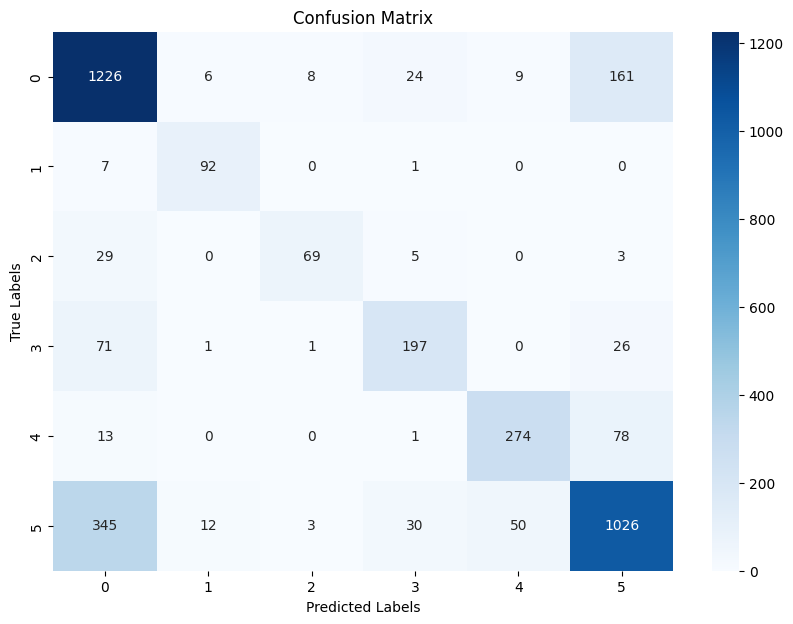

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel(output_file_path)

# Elvárt címkék és predikciók kinyerése
true_labels = df[label_column].tolist()
predicted_labels = df[prediction_column].tolist()

# Kiértékelés
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Eredmények kiírása
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Zavarmátrix plotolása
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_labels, zero_division=0))

              precision    recall  f1-score   support

           0       0.73      0.85      0.78      1434
           1       0.83      0.92      0.87       100
           2       0.85      0.65      0.74       106
           3       0.76      0.67      0.71       296
           4       0.82      0.75      0.78       366
           5       0.79      0.70      0.74      1466

    accuracy                           0.77      3768
   macro avg       0.80      0.76      0.77      3768
weighted avg       0.77      0.77      0.76      3768

